# Project _Kaudruck_ - Pixelweight correction model

### Setup

In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import numpy as np
from skimage import io
import pandas as pd

In [33]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = "large"

In [34]:
src_dir = os.path.abspath(os.path.join(os.pardir, 'src'))
sys.path.append(src_dir)

In [35]:
from kaudruck import KauDruck, plot_aoi_aor

## Empirical data

In [36]:
df = pd.read_excel('../data/empirical/Serie1_Gewichts-Flächenwerte.xlsx', 
                    skiprows=list(range(16)),
                   usecols=[8, 9,10,11,12],
                   skipfooter=6
                    )
df

,Kraft [N],FG/ Pixel- 4 mm,"FG/ Pixel- 6,5 mm",FG/ Pixel- 12 mm
0,2,0.330,0.321,0.310
1,5,0.376,0.364,0.348
2,10,0.394,0.393,0.383
3,20,0.405,0.415,0.407
4,30,0.416,0.423,0.427
5,40,0.425,0.425,0.430
6,50,0.429,0.432,0.443
7,60,0.443,0.435,0.446
8,70,0.441,0.439,0.449
9,80,NaN,0.443,0.451


In [37]:
df['mean_FG'] = df[[x for x in df.columns if x.startswith("FG")]].mean(axis=1)

In [38]:
df.columns = [x.strip().replace('-',"").replace('/',"").replace(',',".").replace(' ',"_") for x in df.columns]
df.columns 

Index(['Kraft_[N]', 'FG_Pixel_4_mm', 'FG_Pixel_6.5_mm', 'FG_Pixel_12_mm',
       'mean_FG'],
      dtype='object')

### Plotting

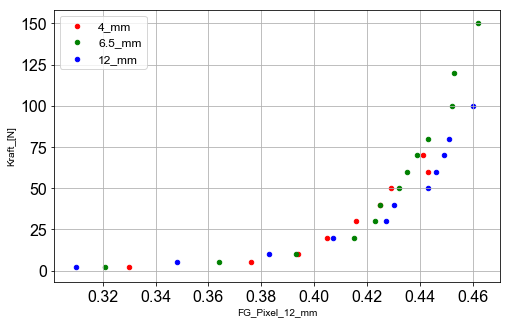

In [39]:
fig, ax = plt.subplots(figsize=(8,5))
df.plot.scatter(x='FG_Pixel_4_mm', y='Kraft_[N]', ax=ax, label='4_mm', color='r')
df.plot.scatter(x='FG_Pixel_6.5_mm', y='Kraft_[N]', ax=ax, label='6.5_mm', color='g')
df.plot.scatter(x='FG_Pixel_12_mm', y='Kraft_[N]', ax=ax, label='12_mm', color='b')

ax.grid()

## Modelling

### Mean model

In [40]:
df

,Kraft_[N],FG_Pixel_4_mm,FG_Pixel_6.5_mm,FG_Pixel_12_mm,mean_FG
0,2,0.330,0.321,0.310,0.320333
1,5,0.376,0.364,0.348,0.362667
2,10,0.394,0.393,0.383,0.390000
3,20,0.405,0.415,0.407,0.409000
4,30,0.416,0.423,0.427,0.422000
5,40,0.425,0.425,0.430,0.426667
6,50,0.429,0.432,0.443,0.434667
7,60,0.443,0.435,0.446,0.441333
8,70,0.441,0.439,0.449,0.443000
9,80,NaN,0.443,0.451,0.447000


In [46]:
from scipy.optimize import curve_fit
#def f(x, a, b, n):
#    return a * x ** n  / (x ** n + b)

def f(x, a, b, c):
    return a * np.exp(b * x) + c

y = df['Kraft_[N]'].values
x = df['mean_FG'].values

popt, pcov = curve_fit(f, x, y)
fitted = f(x, *popt)

In [51]:
x

array([0.32033333, 0.36266667, 0.39      , 0.409     , 0.422     ,
       0.42666667, 0.43466667, 0.44133333, 0.443     , 0.447     ,
       0.456     , 0.453     , 0.462     ])

In [52]:
y

array([  2,   5,  10,  20,  30,  40,  50,  60,  70,  80, 100, 120, 150])

In [53]:
popt

array([1.12524573e-06, 4.04200867e+01, 2.20984718e+00])

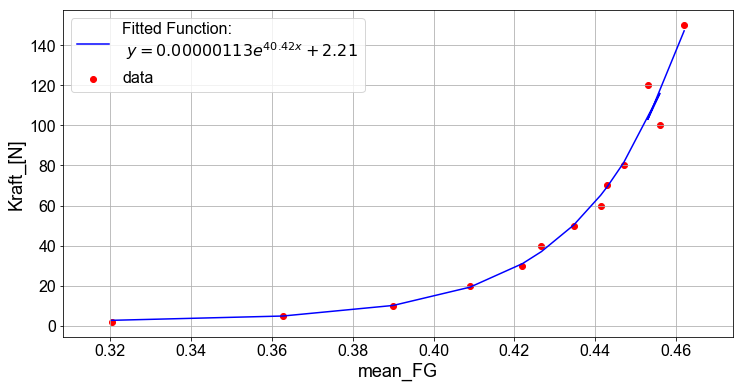

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
#a * np.exp(b * x) + c
ax.scatter(x=x, 
           y=y,
           marker='o', color="r", label="data")
ax.plot(x, fitted, color="blue",
      label='Fitted Function:\n ' + r'$y =  %0.8f e^{%0.2fx} + %0.2f$' % (popt[0],popt[1],popt[2]))
        
ax.grid()
ax.set_xlabel('mean_FG', size=18)
ax.set_ylabel('Kraft_[N]', size=18)
ax.legend(fontsize=16);

### Save model for further usage

In [55]:
import json
with open('../models/pixelweight_correction.json', 'w') as f:
    json.dump({'force_N':y.tolist(), 'pixelweight':x.tolist()}, f)

In [56]:
(x,y)

(array([0.32033333, 0.36266667, 0.39      , 0.409     , 0.422     ,
        0.42666667, 0.43466667, 0.44133333, 0.443     , 0.447     ,
        0.456     , 0.453     , 0.462     ]),
 array([  2,   5,  10,  20,  30,  40,  50,  60,  70,  80, 100, 120, 150]))

***